# Sentiment analysis
# binary calssifiation

In [1]:
import shutil

import matplotlib.pyplot as plt
import os
import re
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file(
    "aclImdb_v1", url, extract=True, cache_dir= '.',
    cache_subdir = '')

In [3]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [5]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [17]:
#load dataset
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [18]:
batch_size = 32
seed = 42

raw_train_ds =tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [19]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("review", text_batch.numpy()[i])
        print("label", label_batch.numpy()[i])

review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
label 0
review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [20]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("label 1 corresponds to ",raw_train_ds.class_names[1])

Label 0 corresponds to neg
label 1 corresponds to  pos


In [21]:
raw_valid_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [22]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size,
)

Found 25000 files belonging to 2 classes.


prepare dataset for training

Standardize, Tokenize and vectorize

In [31]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    tripped_html = tf.strings.regex_replace(lowercase, '<br />', '')
    return tf.strings.regex_replace(tripped_html, '[%s]' % re.escape(string.punctuation), '')

In [32]:
max_features = 10000
sequence_length = 250
vectorized_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
)

In [33]:
train_text = raw_train_ds.map(lambda x, y:x)
vectorized_layer.adapt(train_text)

In [34]:
# create a function to see the result of using this layer to preprocess some data
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorized_layer(text),label

In [38]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print('Review', first_review)
print("Label", first_label)
print("Vectorized Review", vectorize_text(first_review, first_label))


Review tf.Tensor(b'Every scene was put together perfectly.This movie had a wonderful cast and crew. I mean, how can you have a bad movie with Robert Downey Jr. in it,none have and ever will exist. He has the ability to brighten up any movie with his amazing talent.This movie was perfect! I saw this movie sitting all alone on a movie shelf in "Blockbuster" and like it was calling out to me,I couldn\'t resist picking it up and bringing it home with me. You can call me a sappy romantic, but this movie just touched my heart, not to mention made me laugh with pleasure at the same time. Even though it made me cry,I admit, at the end, the whole movie just brightened up my outlook on life thereafter.I suggested to my horror, action, and pure humor movie buff of a brother,who absolutely adored this movie. This is a movie with a good sense of feeling.It could make you laugh out loud, touch your heart, make you fall in love,and enjoy your life.Every time you purposefully walk past this movie, jus

In [41]:
print("1287 ---> ",vectorized_layer.get_vocabulary()[166])
print(" 313 ---> ",vectorized_layer.get_vocabulary()[291])
print('Vocabulary size: {}'.format(len(vectorized_layer.get_vocabulary())))

1287 --->  every
 313 --->  together
Vocabulary size: 10000


In [42]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_valid_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [43]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [44]:
embedding_dim = 16

In [45]:
model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.compile(loss=losses.BinaryCrossentropy(), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [47]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - binary_accuracy: 0.5806 - loss: 0.6817 - val_binary_accuracy: 0.7274 - val_loss: 0.6154
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.7514 - loss: 0.5835 - val_binary_accuracy: 0.8060 - val_loss: 0.5011
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.8167 - loss: 0.4743 - val_binary_accuracy: 0.8358 - val_loss: 0.4285
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.8468 - loss: 0.4032 - val_binary_accuracy: 0.8470 - val_loss: 0.3860
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.8640 - loss: 0.3569 - val_binary_accuracy: 0.8534 - val_loss: 0.3585
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.8774 - loss: 0.3248 - val_binary_accuracy: 0.8582 - val_loss: 0.3408
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8841 - loss: 0.3000 - val_binary_accuracy: 0.8596 - val_loss: 0.3292
Epoc

In [48]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - binary_accuracy: 0.8559 - loss: 0.3333
Loss:  0.3357830047607422
Accuracy:  0.8542799949645996


In [49]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

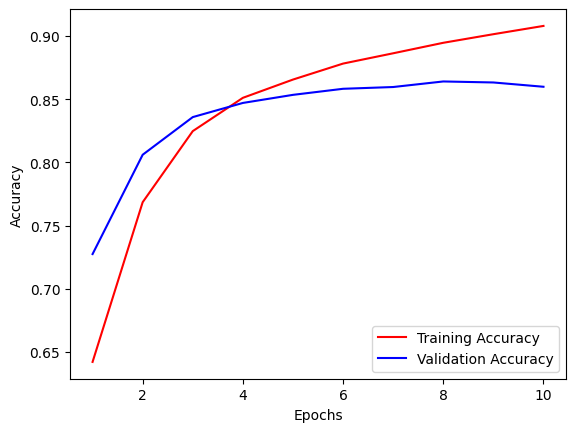

In [52]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

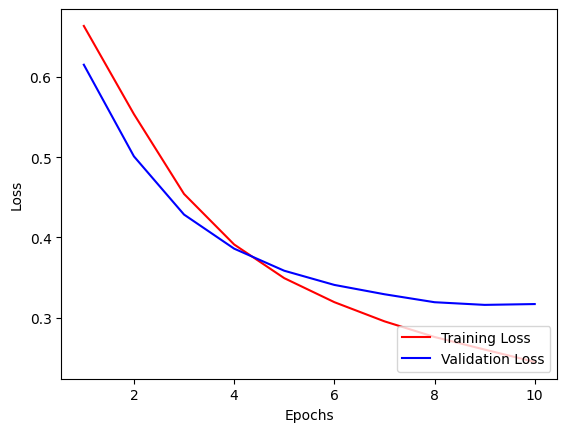

In [53]:

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

Export Model

The model will be capable to take string input.

Add TextVectorization layer to the trained model

In [54]:
export_model = tf.keras.Sequential([
    vectorized_layer,
    model,
    layers.Activation('sigmoid')
])
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer='adam', metrics=['accuracy']
)
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.4973 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
{'accuracy': 0.5, 'binary_accuracy': 0.0, 'loss': 0.0}


In [56]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


array([[0.5833348 ],
       [0.54834485],
       [0.53535753]], dtype=float32)